In [88]:
import os
import numpy as np
import argparse
# from ouster import client, pcap
from ouster.sdk import client, pcap
from contextlib import closing
from more_itertools import nth
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import math

In [91]:
# Sensor Configuration
data_dim = [32, 2048]
deg_left = 140
deg_right = 220

In [106]:
pixel_ratio = data_dim[1]/360
left_pixel = math.floor(deg_left * pixel_ratio / 10) * 10
right_pixel = math.ceil(deg_right * pixel_ratio / 10) * 10
left_pixel -= 1
right_pixel -= 1
data_dim = right_pixel-left_pixel
print(left_pixel, right_pixel)

789 1259


In [301]:
def StatisticalCalc(frame):
    params = []
    for ind in range(frame.shape[-1]):
        data = frame[:,:,ind].flatten()        
        meanval = np.mean(data)
        varval = np.std(data)
        medval = np.median(data)
        q1val = np.percentile(data, 25)
        q3val = np.percentile(data, 75)
        minval = np.min(data)
        maxval = np.max(data)
        ptsval = np.count_nonzero(data)
        skewval = skew(data) if not np.isnan(skew(data)) else 0
        kurtval = kurtosis(data) if not np.isnan(kurtosis(data)) else 0
        params.extend([meanval, varval, minval, q1val, medval, q3val, maxval, skewval, kurtval, ptsval])
    return params

# Experiments 1, 2, 3

In [302]:
folder_path =  r"D:\LiDAR\RawData"
folders = ["18_09_2024_2gSodium","20_09_2024_2gSodium","24_10_2024_2gSodium"]
degen_start_time = np.array([127, 140, 125]) * 10
folder_list = [folder_path + "\\" + i for i in folders]
folder_list

['D:\\LiDAR\\RawData\\18_09_2024_2gSodium',
 'D:\\LiDAR\\RawData\\20_09_2024_2gSodium',
 'D:\\LiDAR\\RawData\\24_10_2024_2gSodium']

## Statistical Data Extraction

In [303]:
folders = folder_list
fps = 10
df = pd.DataFrame(index = np.arange(30000), 
                  columns=['Exp', 'Folder', 'Mode', 'Frame', 
                           'MeanR', 'VarR', 'MinR', 'Q1R','MedR', 'Q3R','MaxR', 'SkewR', 'KurtR','PtsR',
                           'MeanSig', 'VarSig','MinSig', 'Q1Sig','MedSig', 'Q3Sig','MaxSig','SkewSig', 'KurtSig','PtsSig', 
                           'MeanRef', 'VarRef', 'MinRef','Q1Ref', 'MedRef', 'Q3Ref','MaxRef','SkewRef', 'KurtRef','PtsRef',
                           'MeanIR', 'VarIR', 'MinIR','Q1IR','MedIR', 'Q3IR','MaxIR', 'SkewIR', 'KurtIR','PtsIR'])
row_counter = 0
folder_count = -1
for folder in folders:
    folder_count += 1
    rootfolder = folder.split("\\")[-1]
    for subfolder in os.listdir(folder):
        full_path = folder + "\\" + subfolder
        if "Full" not in subfolder:
            continue
        counter = 0
        if os.path.isdir(full_path):
            file_name = 'OS-1-32-122147000654-2048x10'
            intdata = np.empty(shape=(32,data_dim, 4, 1))
            fulldata = np.empty(shape=(32,data_dim, 4, 1))
            frame_counter = 0
            if os.path.isfile(full_path + "\\" + file_name + '.json') :
                metadata_path = full_path + "\\" + file_name + '.json'
                pcap_path = full_path + "\\" + file_name + '.pcap'
                print(f"File {metadata_path} Located...")
                with open(metadata_path, 'r') as f:                    
                    metadata = client.SensorInfo(f.read())
                    print(f"Loading {pcap_path} File...")
                    source = pcap.Pcap(pcap_path, metadata)
                    with closing(client.Scans(source)) as scans:
                        for scan in tqdm(scans):
                            rangedata = client.destagger(metadata, scan.field(client.ChanField.RANGE))
                            rangedata = rangedata[:, left_pixel:right_pixel]
                            sigdata = client.destagger(metadata, scan.field(client.ChanField.SIGNAL)) 
                            sigdata = sigdata[:, left_pixel:right_pixel]
                            refdata = client.destagger(metadata, scan.field(client.ChanField.REFLECTIVITY))
                            refdata = refdata[:, left_pixel:right_pixel]
                            irdata = client.destagger(metadata, scan.field(client.ChanField.NEAR_IR))
                            irdata = irdata[:, left_pixel:right_pixel]
                            testdata = np.stack([rangedata, sigdata, refdata, irdata], axis=-1)
                            if counter >= degen_start_time[folder_count]:                                 
                                if frame_counter < 10:                             
                                    intdata = np.concatenate([intdata, np.expand_dims(testdata, axis=-1)], axis=3) 
                                    frame_counter += 1
                                else:
                                    frame_counter = 0
                                    MeanFrame = np.mean(intdata[:,:,:,1:], axis=3)
                                    header = [rootfolder, subfolder, 'Degen', counter]
                                    statparams = StatisticalCalc(MeanFrame)                                
                                    df.iloc[row_counter, :4] = header 
                                    df.iloc[row_counter, 4:] = np.array(statparams, dtype=float)
                                    intdata = np.empty(shape=(32,data_dim, 4, 1))
                                    intdata = np.concatenate([intdata, np.expand_dims(testdata, axis=-1)], axis=3) 
                                    frame_counter += 1
                                    row_counter += 1
                                    counter += 1
                            else:
                                MeanFrame = testdata
                                header = [rootfolder, subfolder, 'Gen', counter]
                                statparams = StatisticalCalc(MeanFrame)                                
                                #df.loc[row_counter] = header + statparams   
                                df.iloc[row_counter, :4] = header 
                                df.iloc[row_counter, 4:] = np.array(statparams, dtype=float)
                                row_counter += 1
                                counter += 1
            
df.dropna(inplace=True)
df.to_csv("ConsolidatedData.csv")                  

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\3253401641.py:31: DeprecationWarning: pcap.Pcap(...) is deprecated: Use pcap.PcapMultiPacketReader(...).single_source(0) instead. This API is planned to be removed in Q4 2024.
  source = pcap.Pcap(pcap_path, metadata)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\3253401641.py:32: DeprecationWarning: client.Scans(...) is deprecated: Use client.ScansMulti(...).single_source(0) or the appropriate scan source directly instead. This API is planned to be removed in Q4 2024.
  with closing(client.Scans(source)) as scans:


File D:\LiDAR\RawData\18_09_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\18_09_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


37960it [11:25, 55.39it/s]


File D:\LiDAR\RawData\20_09_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\20_09_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


38420it [13:01, 49.18it/s]


File D:\LiDAR\RawData\24_10_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\24_10_2024_2gSodium\01_Full\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


38342it [09:34, 66.71it/s]


In [307]:
param_colums = list(df.columns)[4:]
print(param_colums)
df[param_colums] = df[param_colums].astype(float)

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14998 entries, 0 to 14997
Data columns (total 44 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Exp      14998 non-null  object 
 1   Folder   14998 non-null  object 
 2   Mode     14998 non-null  object 
 3   Frame    14998 non-null  object 
 4   MeanR    14998 non-null  float64
 5   VarR     14998 non-null  float64
 6   MinR     14998 non-null  float64
 7   Q1R      14998 non-null  float64
 8   MedR     14998 non-null  float64
 9   Q3R      14998 non-null  float64
 10  MaxR     14998 non-null  float64
 11  SkewR    14998 non-null  float64
 12  KurtR    14998 non-null  float64
 13  PtsR     14998 non-null  float64
 14  MeanSig  14998 non-null  float64
 15  VarSig   14998 non-null  float64
 16  MinSig   14998 non-null  float64
 17  Q1Sig    14998 non-null  float64
 18  MedSig   14998 non-null  float64
 19  Q3Sig    14998 non-null  float64
 20  MaxSig   14998 non-null  float64
 21  SkewSig  149

## Normalize parameters with initial samples

In [333]:
exp_name = list(df['Exp'].unique())
exp_name

['18_09_2024_2gSodium', '20_09_2024_2gSodium', '24_10_2024_2gSodium']

In [314]:
background_ref = []
for exp in exp_name:
    init_samples = df[(df['Exp'] == exp) & (df['Mode'] == 'Gen')].iloc[5:55]
    bg_value = init_samples.mean()
    bg_value = bg_value.apply(lambda x: 1 if x==0 else x) # Change 0 to 1 to avoid division by zero error
    background_ref.append(bg_value)
background_ref = pd.DataFrame(background_ref)
background_ref.to_csv('BackgroundReferenceValue')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\2422357800.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  bg_value = init_samples.mean()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\2422357800.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  bg_value = init_samples.mean()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\2422357800.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecat

In [315]:
df_norm = df.copy()
for i in range(len(exp_name)):    
    df_norm.loc[df_norm['Exp']==exp_name[i], param_colums] = df_norm[df_norm['Exp']==exp_name[i]][param_colums]/background_ref[param_colums].loc[i]

In [316]:
df_norm.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,MeanIR,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR
0,18_09_2024_2gSodium,01_Full,Gen,0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.267519,1.198420,0.0,0.000000,0.000000,0.000000,0.700784,-2.628093,0.142220,0.246812
1,18_09_2024_2gSodium,01_Full,Gen,1,1.111522,4.800980,0.0,0.0,0.0,0.0,...,0.999830,1.000543,0.0,0.997697,0.998055,0.999506,1.018119,0.992285,1.002041,1.000000
2,18_09_2024_2gSodium,01_Full,Gen,2,0.992983,0.997110,0.0,0.0,0.0,0.0,...,1.000081,1.000164,0.0,0.996069,0.998674,0.999506,1.002938,0.984823,1.023456,1.000000
3,18_09_2024_2gSodium,01_Full,Gen,3,1.003841,1.000466,0.0,0.0,0.0,0.0,...,1.000179,1.000456,0.0,1.000952,1.001152,1.000568,1.010284,0.990239,1.011434,1.000000
4,18_09_2024_2gSodium,01_Full,Gen,4,0.988587,0.994591,0.0,0.0,0.0,0.0,...,0.999544,1.000173,0.0,0.999325,0.998674,0.999506,0.998041,0.986015,1.006867,1.000000


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\743768137.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,2))


<Figure size 640x480 with 0 Axes>

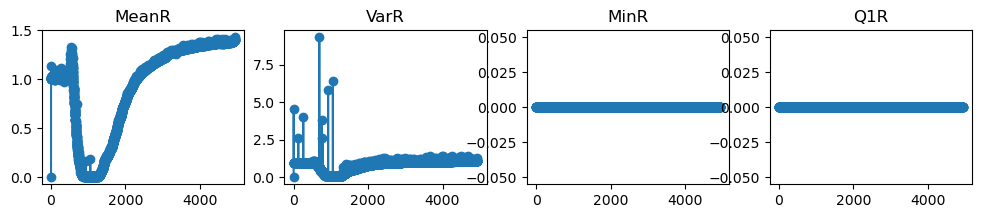

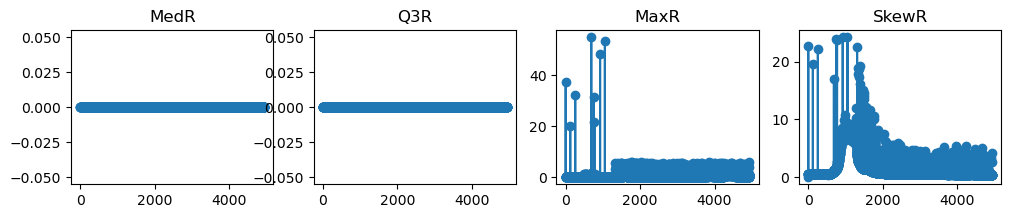

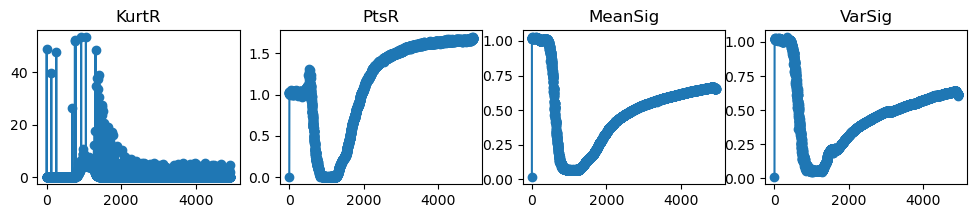

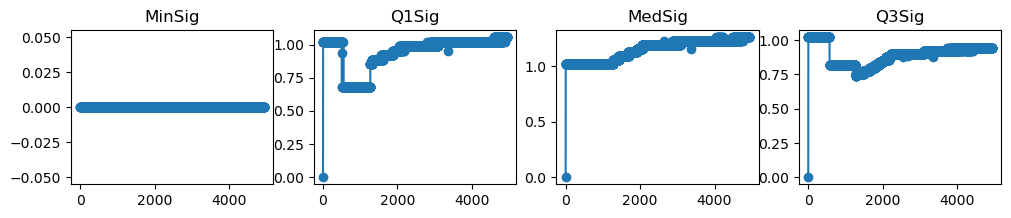

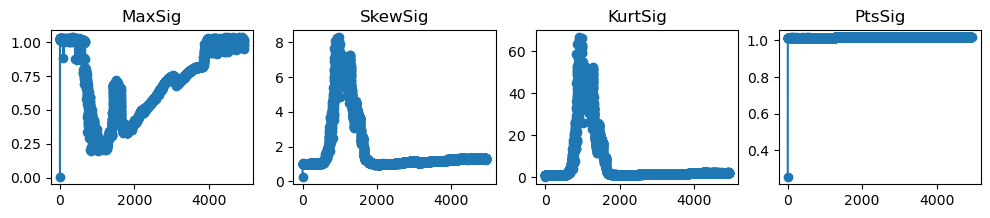

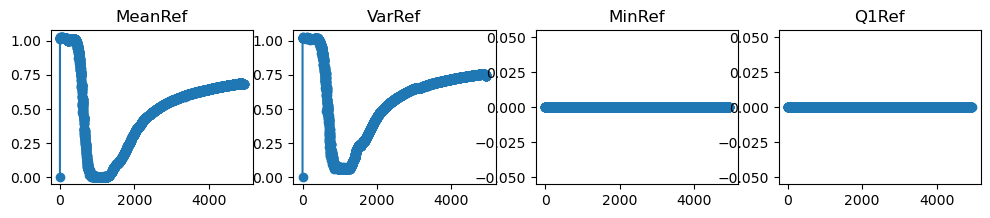

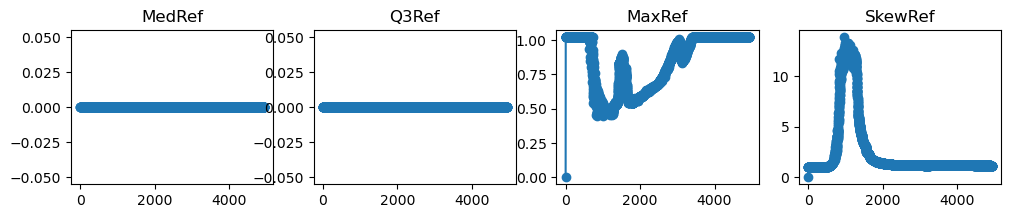

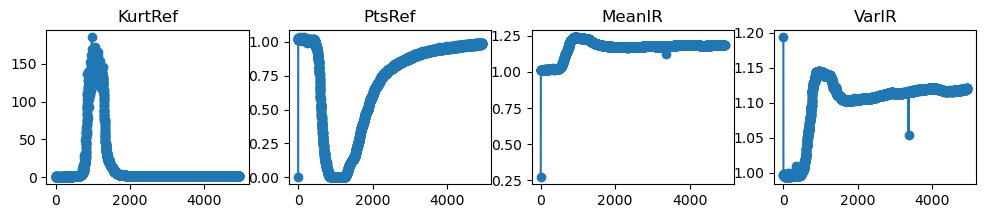

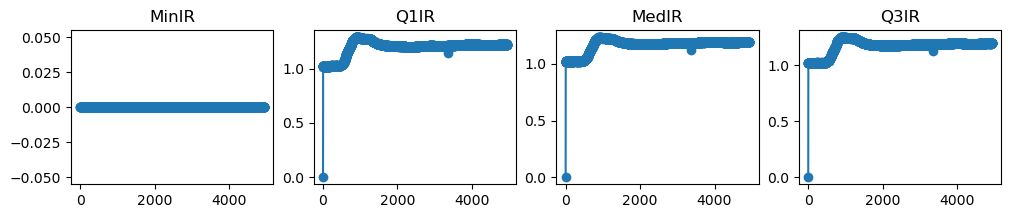

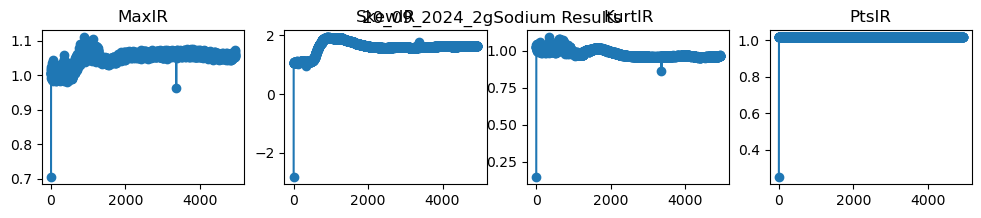

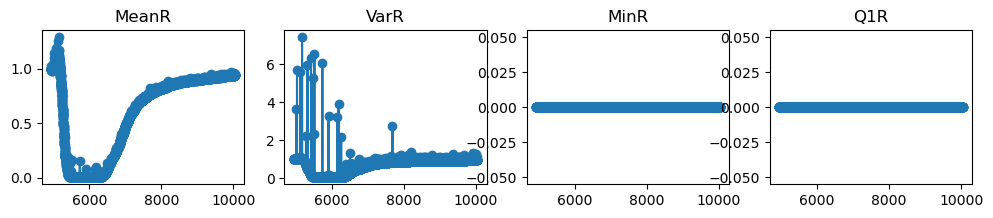

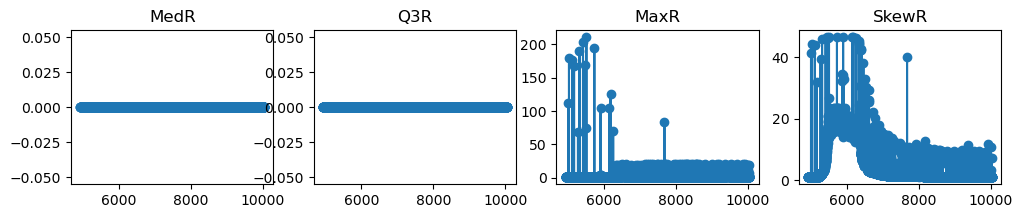

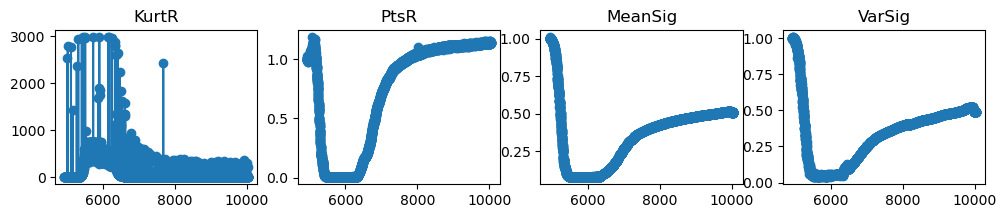

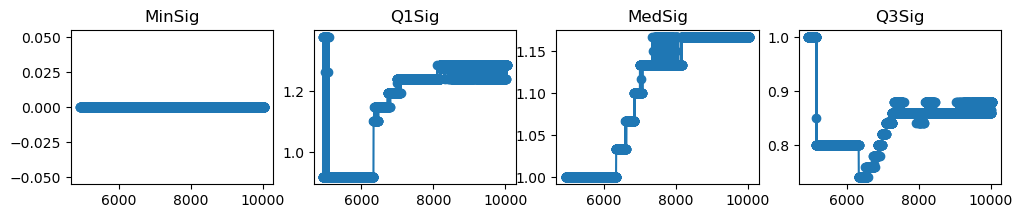

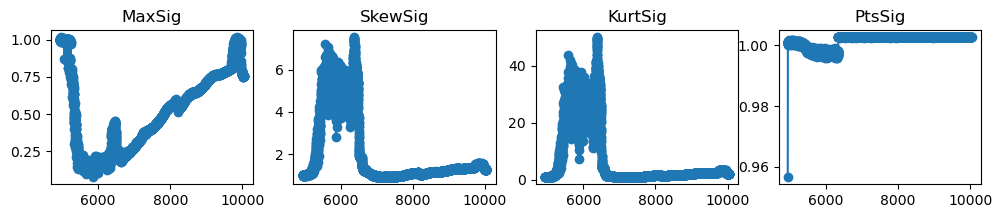

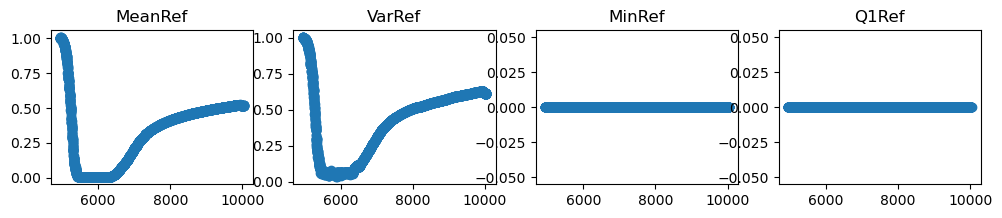

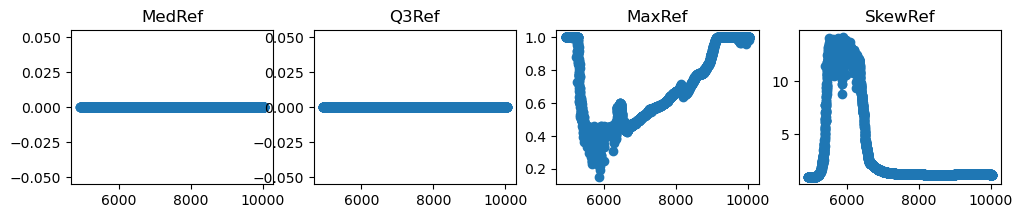

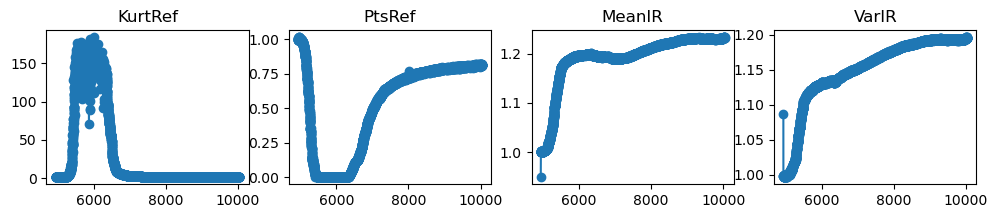

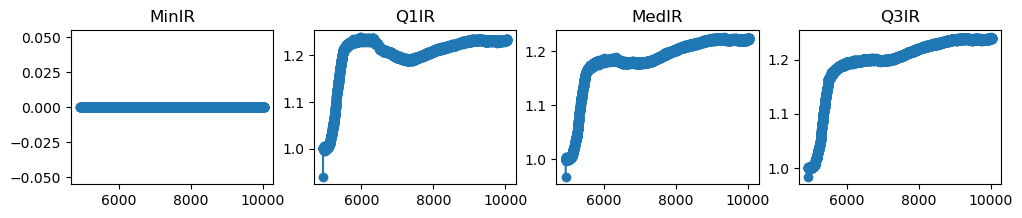

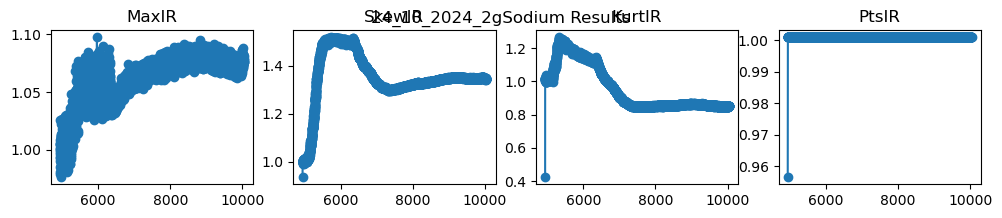

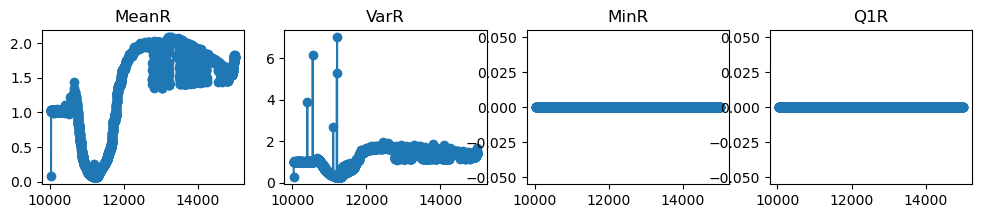

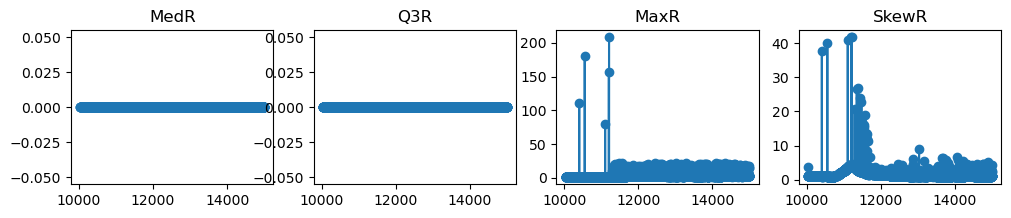

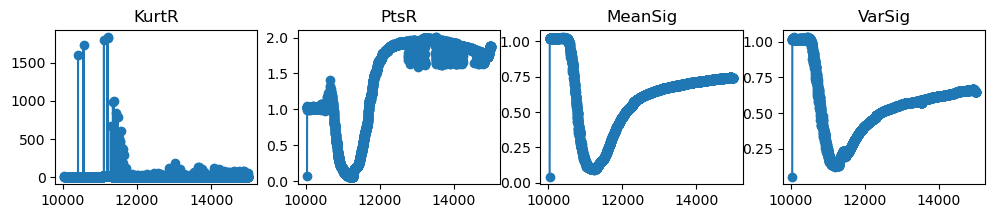

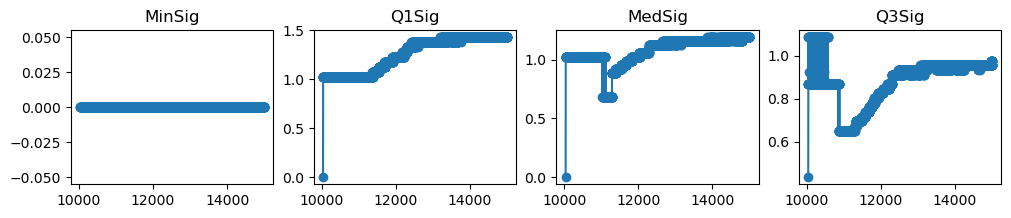

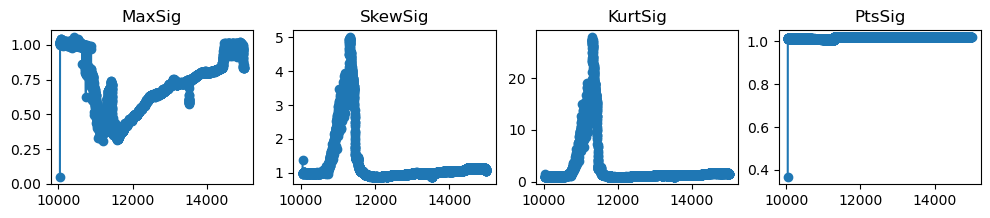

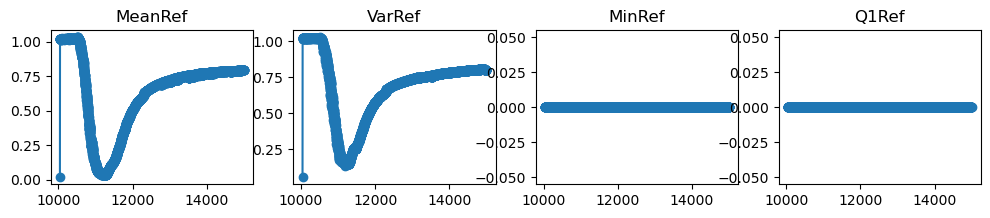

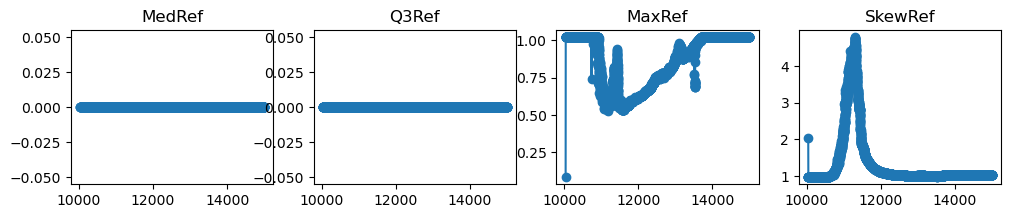

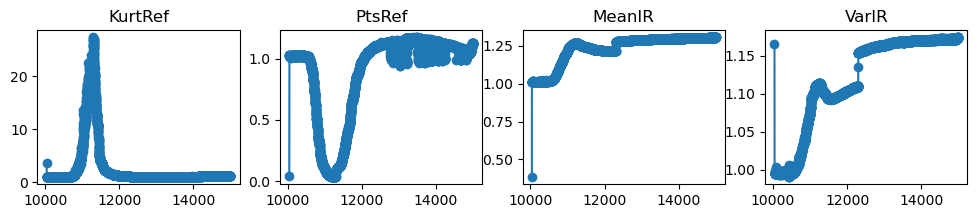

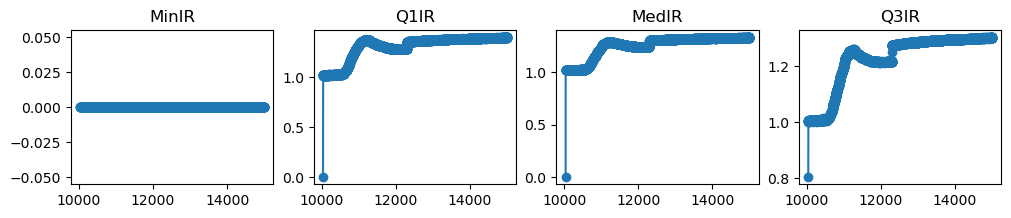

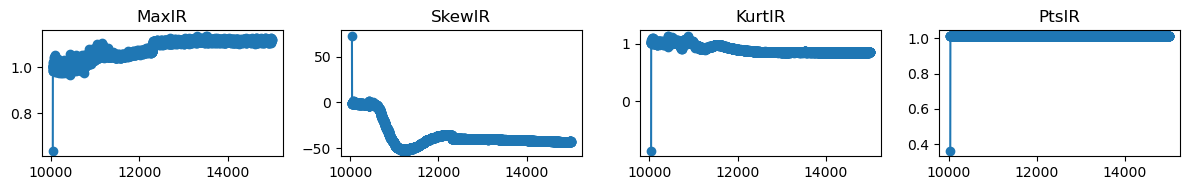

In [313]:
for exp in exp_name:
    temp_df = df_norm[df_norm['Exp'] == exp]
    plt.suptitle(exp + " Results")
    for j in range(len(param_colums)):
        data = temp_df[param_colums[j]]
        if j%4 == 0:
            plt.figure(figsize=(12,2))
            #plt_cnt = 1
        plt.subplot(1,4,j%4 + 1)
        plt.plot(data, marker='o')
        plt.title(param_colums[j])
        #plt_cnt += 1
plt.tight_layout()

## Map Concentration to Sensor Data

In [342]:
# Load Smoke Concentration data
exp1_conc = pd.read_csv("ConcInterpExp1.csv")
exp2_conc = pd.read_csv("ConcInterpExp2.csv")
exp3_conc = pd.read_csv("ConcInterpExp3.csv")
exp_conc = pd.concat([exp1_conc, exp2_conc, exp3_conc], axis=0)
exp_conc = exp_conc.reset_index(drop=True)

In [356]:
df_norm_degen = df_norm[df_norm['Mode'] != 'Gen'].reset_index(drop=True).copy()
df_norm_gen = df_norm[df_norm['Mode'] == 'Gen'].reset_index(drop=True).copy()

In [360]:
len(exp_conc), len(df_norm_degen)

(11078, 11078)

In [361]:
df_norm_degen.tail()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,MeanIR,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR
11073,24_10_2024_2gSodium,01_Full,Degen,4954,1.763893,1.391895,0.0,0.0,0.0,0.0,...,1.289656,1.177223,0.0,1.370399,1.304303,1.295640,1.108950,86.965327,0.822031,1.0
11074,24_10_2024_2gSodium,01_Full,Degen,4955,1.797108,1.625617,0.0,0.0,0.0,0.0,...,1.289567,1.177210,0.0,1.370892,1.302022,1.294994,1.106223,87.029326,0.820896,1.0
11075,24_10_2024_2gSodium,01_Full,Degen,4956,1.767695,1.401953,0.0,0.0,0.0,0.0,...,1.290071,1.177652,0.0,1.367334,1.304539,1.297192,1.110680,86.844406,0.823329,1.0
11076,24_10_2024_2gSodium,01_Full,Degen,4957,1.775214,1.480612,0.0,0.0,0.0,0.0,...,1.290681,1.178195,0.0,1.370837,1.304067,1.296125,1.112043,87.122386,0.818923,1.0
11077,24_10_2024_2gSodium,01_Full,Degen,4958,1.750457,1.386415,0.0,0.0,0.0,0.0,...,1.290265,1.177574,0.0,1.370892,1.304382,1.297321,1.107062,87.230582,0.820890,1.0


In [363]:
df_norm_degen['Concentration'] = exp_conc['Data']

In [364]:
df_norm_degen.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR,Concentration
0,18_09_2024_2gSodium,01_Full,Degen,1270,0.011956,0.129460,0.0,0.0,0.0,0.0,...,1.138393,0.0,1.242808,1.196550,1.211091,1.044270,1.773443,0.983807,1.0,2030.110000
1,18_09_2024_2gSodium,01_Full,Degen,1271,0.009799,0.095385,0.0,0.0,0.0,0.0,...,1.138973,0.0,1.242930,1.196922,1.211649,1.042752,1.774462,0.980042,1.0,2022.796748
2,18_09_2024_2gSodium,01_Full,Degen,1272,0.011616,0.113608,0.0,0.0,0.0,0.0,...,1.139380,0.0,1.243419,1.196984,1.211622,1.036582,1.771977,0.982781,1.0,2015.548649
3,18_09_2024_2gSodium,01_Full,Degen,1273,0.009920,0.092299,0.0,0.0,0.0,0.0,...,1.138379,0.0,1.244232,1.196922,1.210374,1.038002,1.771729,0.985877,1.0,2008.365266
4,18_09_2024_2gSodium,01_Full,Degen,1274,0.009822,0.094579,0.0,0.0,0.0,0.0,...,1.138545,0.0,1.242483,1.197728,1.210693,1.047502,1.768001,0.984631,1.0,2001.246166


## Extract Range of each experiment

In [367]:
for i in range(len(exp_name)):
    t = degen_start_time[i]
    df_norm_degen.loc[df_norm_degen['Exp']==exp_name[i],'Frame_mod'] = df_norm_degen[df_norm_degen['Exp']==exp_name[i]]['Frame'].apply(lambda x: x-t+(t//10))

In [341]:
df_norm_degen.groupby("Exp")['Frame_mod'].min(), df_norm_degen.groupby("Exp")['Frame_mod'].max()

(Exp
 18_09_2024_2gSodium    127
 20_09_2024_2gSodium    140
 24_10_2024_2gSodium    125
 Name: Frame_mod, dtype: int64,
 Exp
 18_09_2024_2gSodium    3794
 20_09_2024_2gSodium    3840
 24_10_2024_2gSodium    3833
 Name: Frame_mod, dtype: int64)

In [400]:
df_norm_degen.drop('Frame_mod', axis=1, inplace=True)

## Verify the mapping

In [366]:
Exp1_time = [127, 247, 367, 487, 607, 732, 852, 1032, 1922, 3732]
Exp2_time = [140, 260, 380, 500, 620, 740, 870, 1050, 1950, 3750]
Exp3_time = [125, 250, 370, 494, 621, 741, 868, 1054, 1962, 3762]
exp_time = [Exp1_time, Exp2_time, Exp3_time]

Exp1_data = [2030.11, 1495.71, 1155.13, 628.36, 531.54, 289.69, 234.99, 176.48, 144.65, 162.19]
Exp2_data = [1704.39, 1476.42, 1292.76, 1067.22, 767.64, 209.29, 174.57, 221.29, 137.35, 107.61]
Exp3_data = [1803.12, 1254.7, 940.73, 460.25, 226.65, 144.26, 107.25, 66.35, 50.73, 66.63]
exp_data = [Exp1_data, Exp2_data, Exp3_data]

In [373]:
for i, exp in enumerate(exp_name):
    time = exp_time[i]
    print(exp + " Results:")
    for j in range(len(time)):
        testval = df_norm_degen[(df_norm_degen['Exp'] == exp) & (df_norm_degen['Frame_mod'] == time[j])]['Concentration']
        print(time[j], testval.iloc[0])

18_09_2024_2gSodium Results:
127 2030.11
247 1495.71
367 1155.13
487 628.3600000000001
607 531.54
732 289.69
852 234.99
1032 176.48
1922 144.65
3732 162.19
20_09_2024_2gSodium Results:
140 1704.39
260 1476.4200000000003
380 1292.76
500 1067.22
620 767.6399999999999
740 209.29
870 174.57
1050 221.29
1950 137.35
3750 107.61
24_10_2024_2gSodium Results:
125 1803.12
250 1254.7
370 940.73
494 460.25
621 226.65
741 144.26
868 107.25
1054 66.35
1962 50.73000000000001
3762 66.63


# Experiment 4

In [374]:
# 08 Apr 2024 Experiment data extraction
folders = [r"D:\LiDAR\RawData\08_04_2024_2gSodiumForDA"]
fps = 10
df_exp4 = pd.DataFrame(index = np.arange(30000), 
                  columns=['Exp', 'Folder', 'Mode', 'Frame', 
                           'MeanR', 'VarR', 'MinR', 'Q1R','MedR', 'Q3R','MaxR', 'SkewR', 'KurtR','PtsR',
                           'MeanSig', 'VarSig','MinSig', 'Q1Sig','MedSig', 'Q3Sig','MaxSig','SkewSig', 'KurtSig','PtsSig', 
                           'MeanRef', 'VarRef', 'MinRef','Q1Ref', 'MedRef', 'Q3Ref','MaxRef','SkewRef', 'KurtRef','PtsRef',
                           'MeanIR', 'VarIR', 'MinIR','Q1IR','MedIR', 'Q3IR','MaxIR', 'SkewIR', 'KurtIR','PtsIR'])
row_counter = 0
folder_count = -1
for folder in folders:
    folder_count += 1
    rootfolder = folder.split("\\")[-1]
    for subfolder in os.listdir(folder):
        full_path = folder + "\\" + subfolder
        counter = 0
        if os.path.isdir(full_path):
            file_name = 'OS-1-32-122147000654-2048x10'
            intdata = np.empty(shape=(32,data_dim, 4, 1))
            fulldata = np.empty(shape=(32,data_dim, 4, 1))
            frame_counter = 0
            if os.path.isfile(full_path + "\\" + file_name + '.json') :
                metadata_path = full_path + "\\" + file_name + '.json'
                pcap_path = full_path + "\\" + file_name + '.pcap'
                print(f"File {metadata_path} Located...")
                with open(metadata_path, 'r') as f:                    
                    metadata = client.SensorInfo(f.read())
                    print(f"Loading {pcap_path} File...")
                    source = pcap.Pcap(pcap_path, metadata)
                    with closing(client.Scans(source)) as scans:
                        for scan in tqdm(scans):
                            rangedata = client.destagger(metadata, scan.field(client.ChanField.RANGE))
                            rangedata = rangedata[:, left_pixel:right_pixel]
                            sigdata = client.destagger(metadata, scan.field(client.ChanField.SIGNAL)) 
                            sigdata = sigdata[:, left_pixel:right_pixel]
                            refdata = client.destagger(metadata, scan.field(client.ChanField.REFLECTIVITY))
                            refdata = refdata[:, left_pixel:right_pixel]
                            irdata = client.destagger(metadata, scan.field(client.ChanField.NEAR_IR))
                            irdata = irdata[:, left_pixel:right_pixel]                            
                            testdata = np.stack([rangedata, sigdata, refdata, irdata], axis=-1)
                            if "00" not in subfolder:                                
                                if frame_counter < 10:                             
                                    intdata = np.concatenate([intdata, np.expand_dims(testdata, axis=-1)], axis=3) 
                                    frame_counter += 1
                                else:
                                    frame_counter = 0
                                    MeanFrame = np.mean(intdata[:,:,:,1:], axis=3)
                                    header = [rootfolder, subfolder, 'Degen', counter]
                                    statparams = StatisticalCalc(MeanFrame)
                                    df_exp4.iloc[row_counter, :4] = header 
                                    df_exp4.iloc[row_counter, 4:] = np.array(statparams, dtype=float)                                    
                                    intdata = np.empty(shape=(32,data_dim, 4, 1))
                                    row_counter += 1
                                    counter += 1
                            else:
                                MeanFrame = testdata
                                header = [rootfolder, subfolder, 'Gen', counter]
                                statparams = StatisticalCalc(MeanFrame)                                
                                df_exp4.iloc[row_counter, :4] = header 
                                df_exp4.iloc[row_counter, 4:] = np.array(statparams, dtype=float)
                                row_counter += 1
                                counter += 1    
df_exp4.dropna(inplace=True)
df_exp4.to_csv("Experiment4Data.csv")                  

File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\00\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\00\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\2845904718.py:30: DeprecationWarning: pcap.Pcap(...) is deprecated: Use pcap.PcapMultiPacketReader(...).single_source(0) instead. This API is planned to be removed in Q4 2024.
  source = pcap.Pcap(pcap_path, metadata)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\2845904718.py:31: DeprecationWarning: client.Scans(...) is deprecated: Use client.ScansMulti(...).single_source(0) or the appropriate scan source directly instead. This API is planned to be removed in Q4 2024.
  with closing(client.Scans(source)) as scans:
1532it [00:53, 28.81it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\01\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\01\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1007it [00:26, 37.86it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\02\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\02\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1063it [00:15, 68.45it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\03\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\03\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1209it [00:23, 50.71it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\04\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\04\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1164it [00:13, 84.89it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\05\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\05\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


348it [00:04, 84.33it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\06\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\06\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1028it [00:14, 72.19it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\07\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\07\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1060it [00:19, 53.12it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\08\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\08\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1127it [00:39, 28.63it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\09\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\09\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1067it [00:17, 60.90it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\10\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\10\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


1097it [00:13, 81.49it/s]


File D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\BG\OS-1-32-122147000654-2048x10.json Located...
Loading D:\LiDAR\RawData\08_04_2024_2gSodiumForDA\BG\OS-1-32-122147000654-2048x10.pcap File...
loading metadata from []


215it [00:03, 54.53it/s]


In [375]:
df_exp4[param_colums] = df_exp4[param_colums].astype(float)

## Normalize parameters with initial samples

In [376]:
df_exp4_samples = df_exp4[(df_exp4['Folder'] != '00') & (df_exp4['Folder'] != 'BG')].reset_index(drop=True).copy()
df_exp4_BG = df_exp4[df_exp4['Folder'] == 'BG'].reset_index(drop=True).copy()
df_exp4_Gen = df_exp4[df_exp4['Mode'] == 'Gen'].reset_index(drop=True).copy()

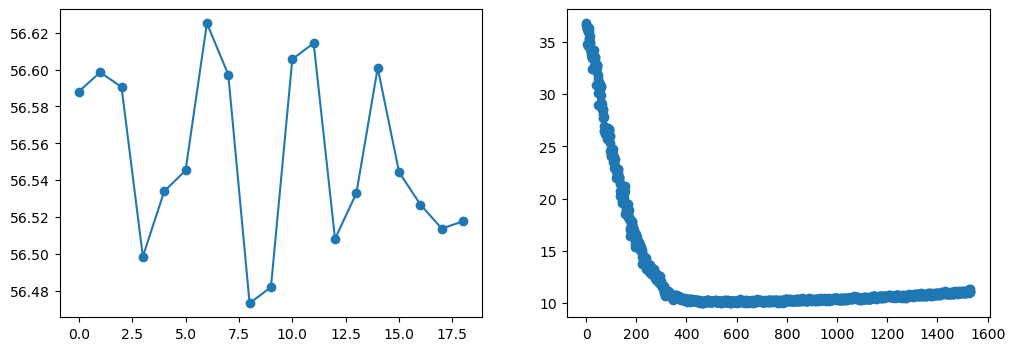

In [377]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(df_exp4_BG['MeanSig'], marker='o')
plt.subplot(1,2,2)
plt.plot(df_exp4_Gen['MeanSig'], marker='o')

In [378]:
bg_value = df_exp4_BG.mean()
bg_value = bg_value.apply(lambda x: 1 if x==0 else x) # Change 0 to 1 to avoid division by zero error
bg_value

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2404\4223667584.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  bg_value = df_exp4_BG.mean()


Frame          9.000000
MeanR         65.855505
VarR         216.654440
MinR           1.000000
Q1R            1.000000
MedR           1.000000
Q3R            1.000000
MaxR        3189.042105
SkewR          3.339098
KurtR         11.819089
PtsR        1504.000000
MeanSig       56.552487
VarSig       209.896634
MinSig         1.000000
Q1Sig          2.784211
MedSig         3.586842
Q3Sig          4.815789
MaxSig      3190.494737
SkewSig        6.497985
KurtSig       51.165971
PtsSig     13675.052632
MeanRef        7.190400
VarRef        25.335341
MinRef         1.000000
Q1Ref          1.000000
MedRef         1.000000
Q3Ref          1.000000
MaxRef       255.000000
SkewRef        4.921000
KurtRef       26.226870
PtsRef      2816.947368
MeanIR       788.862313
VarIR        429.218258
MinIR          1.000000
Q1IR         586.946053
MedIR        783.673684
Q3IR         906.835526
MaxIR       2924.436842
SkewIR         1.088694
KurtIR         3.483191
PtsIR      13723.000000
dtype: float64

### Normalize samples

In [379]:
df_exp4_samples_norm = df_exp4_samples.copy()
df_exp4_samples_norm[param_colums] = df_exp4_samples[param_colums]/bg_value[param_colums]
df_exp4_samples_norm.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,MeanIR,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR
0,08_04_2024_2gSodiumForDA,01,Degen,0,0.376693,0.592468,0.0,0.0,0.0,0.0,...,1.041291,0.878873,0.0,1.090731,1.072896,1.105961,0.821868,0.054752,0.478513,1.0
1,08_04_2024_2gSodiumForDA,01,Degen,1,0.414604,0.656142,0.0,0.0,0.0,0.0,...,1.114397,0.923482,0.0,1.202325,1.163367,1.164930,0.908790,0.049616,0.579021,1.0
2,08_04_2024_2gSodiumForDA,01,Degen,2,0.417792,0.658309,0.0,0.0,0.0,0.0,...,1.115178,0.924298,0.0,1.201814,1.163112,1.166171,0.903935,0.048686,0.576418,1.0
3,08_04_2024_2gSodiumForDA,01,Degen,3,0.420072,0.660808,0.0,0.0,0.0,0.0,...,1.115287,0.924288,0.0,1.202496,1.164324,1.165261,0.913372,0.049185,0.577743,1.0
4,08_04_2024_2gSodiumForDA,01,Degen,4,0.424266,0.661822,0.0,0.0,0.0,0.0,...,1.114227,0.923711,0.0,1.201090,1.163367,1.164654,0.907012,0.050882,0.577495,1.0


### Normalize Generation data

In [380]:
df_exp4_Gen_norm = df_exp4_Gen.copy()
df_exp4_Gen_norm[param_colums] = df_exp4_Gen[param_colums]/bg_value[param_colums]
df_exp4_Gen_norm.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,MeanIR,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR
0,08_04_2024_2gSodiumForDA,00,Gen,0,1.260484,1.142887,0.0,0.0,0.0,0.0,...,1.035521,0.950819,0.0,1.076760,1.052734,1.055318,0.973863,0.638453,0.848354,1.0
1,08_04_2024_2gSodiumForDA,00,Gen,1,1.215500,1.123788,0.0,0.0,0.0,0.0,...,1.035570,0.952224,0.0,1.075056,1.052734,1.056421,0.974205,0.645990,0.852648,1.0
2,08_04_2024_2gSodiumForDA,00,Gen,2,1.260708,1.140863,0.0,0.0,0.0,0.0,...,1.035625,0.950825,0.0,1.076760,1.054010,1.056421,0.963604,0.633501,0.841241,1.0
3,08_04_2024_2gSodiumForDA,00,Gen,3,1.235076,1.132567,0.0,0.0,0.0,0.0,...,1.035976,0.949805,0.0,1.078464,1.054010,1.055318,0.990618,0.629400,0.844936,1.0
4,08_04_2024_2gSodiumForDA,00,Gen,4,1.317713,1.164419,0.0,0.0,0.0,0.0,...,1.036178,0.952266,0.0,1.078464,1.052734,1.057524,0.982411,0.641738,0.849818,1.0


## Extract Frame range for each folder

In [140]:
frame_range = (df_exp4.groupby("Folder")['Frame'].max() - df_exp4.groupby("Folder")['Frame'].min()) + 1
print(frame_range, np.array(frame_range))

Folder
00    1532
01      91
02      96
03     109
04     105
05      31
06      93
07      96
08     102
09      97
10      99
BG      19
Name: Frame, dtype: int64 [1532   91   96  109  105   31   93   96  102   97   99   19]


## Map Concentration to Sensor data

In [381]:
# Verify the split
len(df_exp4_samples) + len(df_exp4_BG) + len(df_exp4_Gen), len(df_exp4)

(2470, 2470)

In [382]:
subfolders = df_exp4_samples_norm['Folder'].unique()
subfolders

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
      dtype=object)

In [383]:
# Load Concentration Data
exp4_conc = pd.read_csv("ConcInterpExp4.csv")
exp4_conc.head()

,Unnamed: 0,Time,Data
0,0,0,58.550000
1,1,1,58.458168
2,2,2,58.366504
3,3,3,58.275008
4,4,4,58.183681


In [384]:
print("Length of concentration data: ", len(exp4_conc))
print("Length of samples data: ", np.sum(df_exp4_samples.groupby('Folder')['Exp'].count()))

Length of concentration data:  919
Length of samples data:  919


In [385]:
df_exp4_samples_norm['Concentration'] = exp4_conc['Data']
df_exp4_samples_norm.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR,Concentration
0,08_04_2024_2gSodiumForDA,01,Degen,0,0.376693,0.592468,0.0,0.0,0.0,0.0,...,0.878873,0.0,1.090731,1.072896,1.105961,0.821868,0.054752,0.478513,1.0,58.550000
1,08_04_2024_2gSodiumForDA,01,Degen,1,0.414604,0.656142,0.0,0.0,0.0,0.0,...,0.923482,0.0,1.202325,1.163367,1.164930,0.908790,0.049616,0.579021,1.0,58.458168
2,08_04_2024_2gSodiumForDA,01,Degen,2,0.417792,0.658309,0.0,0.0,0.0,0.0,...,0.924298,0.0,1.201814,1.163112,1.166171,0.903935,0.048686,0.576418,1.0,58.366504
3,08_04_2024_2gSodiumForDA,01,Degen,3,0.420072,0.660808,0.0,0.0,0.0,0.0,...,0.924288,0.0,1.202496,1.164324,1.165261,0.913372,0.049185,0.577743,1.0,58.275008
4,08_04_2024_2gSodiumForDA,01,Degen,4,0.424266,0.661822,0.0,0.0,0.0,0.0,...,0.923711,0.0,1.201090,1.163367,1.164654,0.907012,0.050882,0.577495,1.0,58.183681


<Axes: xlabel='MeanSig', ylabel='Concentration'>

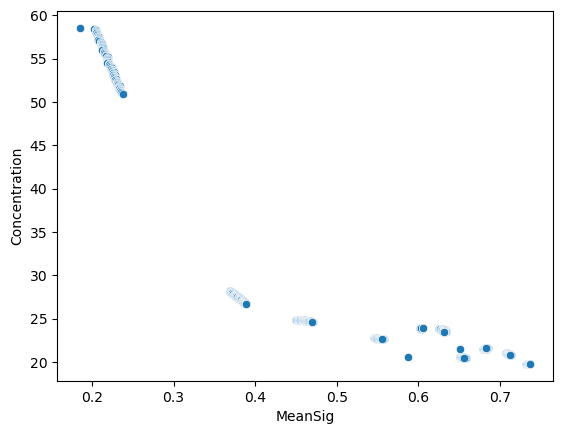

In [207]:
sns.scatterplot(data=df_exp4_samples_norm, x='MeanSig', y='Concentration')

## Verify the mapping

In [388]:
start_time = np.array([0, 600, 1200, 1800, 2520, 3000, 3600, 4200, 4800, 5400])
conc = np.array([58.55, 28.17, 24.89, 22.75, 23.79, 23.85, 20.6, 21.45, 20.99, 19.8])
n_frames = np.array([1532, 91, 96, 109, 105, 31, 93, 96, 102, 97, 99, 19])
n_frames = n_frames[1:-1] # Ignoring smoke generation and BG samples
end_time = start_time + n_frames

In [392]:
df_exp4_samples_norm.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR,Concentration
0,08_04_2024_2gSodiumForDA,01,Degen,0,0.376693,0.592468,0.0,0.0,0.0,0.0,...,0.878873,0.0,1.090731,1.072896,1.105961,0.821868,0.054752,0.478513,1.0,58.550000
1,08_04_2024_2gSodiumForDA,01,Degen,1,0.414604,0.656142,0.0,0.0,0.0,0.0,...,0.923482,0.0,1.202325,1.163367,1.164930,0.908790,0.049616,0.579021,1.0,58.458168
2,08_04_2024_2gSodiumForDA,01,Degen,2,0.417792,0.658309,0.0,0.0,0.0,0.0,...,0.924298,0.0,1.201814,1.163112,1.166171,0.903935,0.048686,0.576418,1.0,58.366504
3,08_04_2024_2gSodiumForDA,01,Degen,3,0.420072,0.660808,0.0,0.0,0.0,0.0,...,0.924288,0.0,1.202496,1.164324,1.165261,0.913372,0.049185,0.577743,1.0,58.275008
4,08_04_2024_2gSodiumForDA,01,Degen,4,0.424266,0.661822,0.0,0.0,0.0,0.0,...,0.923711,0.0,1.201090,1.163367,1.164654,0.907012,0.050882,0.577495,1.0,58.183681


In [397]:
pd.set_option('display.max_rows', None)
df_exp4_samples_norm[['Folder', 'Frame', 'Concentration']]


,Folder,Frame,Concentration
0,01,0,58.550000
1,01,1,58.458168
2,01,2,58.366504
3,01,3,58.275008
4,01,4,58.183681
5,01,5,58.092522
6,01,6,58.001531
7,01,7,57.910708
8,01,8,57.820053
9,01,9,57.729565


In [399]:
pd.set_option('display.max_rows', 10)

# Merge All experimental results

In [404]:
df_final = pd.concat([df_norm_degen, df_exp4_samples_norm], axis=0)

In [411]:
df_final.to_csv("FinalData.csv", index=False)

In [ ]:
# Prepared by Muthukumar G